(ref:sec:adiabatic-pipe-flow)=
# Adiabatic Pipe Flow


Story

- Adiabate Rohrleitung hat keine Energieverluste aber Druckverlust
- Es ist nicht möglich, den Druck ohne Zutun wieder anzuheben, also doch Energieverlust?
- Exergieanalyse zeigt Verlust der Qualität
- Definition Aufwand und Nutzen, Berechnung der Exergiezerstörung

## Introduction

Consider a well insulated pipeline transporting steam as shown in the figure below.

```{figure} /figures/Compressor.svg
---
name: pipeline-flowsheet
---
Abstract model of the well insulated steam pipeline.
```

Measurement data are obtained at the inlet and the outlet of the pipeline:

| Parameter | Location | Value | Unit |
|:--------- |:-------- | -----:| ---- |
| Temperature | Inlet | 195 | °C |
| Temperature |  | 184.4 | °C |
| Pressure | Inlet | 10 | bar |
|  | Outlet | 6 | bar |

First, we can set up the energy balance equation of the thermodynamic open system, where the work $\dot W$ and heat
$\dot Q$ transferred change the enthalpy $h$ of a mass flow $\dot m$ from a state 1 to a different state 2:

```{math}
    :label: eq:pipe-flow-energy-balance
    \dot W + \dot Q = \dot m \cdot \left(h_2 - h_1\right)
```

Since a pipe does not transfer work to the fluid, work transferred can be considered equal to zero. Therefore the 
specific heat transferred can be calculated by the change of enthalpy. Since the pipeline is well insulated, the value
should be rather small.

```{math}
    :label: eq:pipe-flow-energy-balance-simplified
    \frac{\dot Q}{\dot m} = h_2 - h_1\\
```

To do that computationally, we first import the `PropsSI` function from `CoolProp` and then insert the values from the
table above.

In [134]:
from CoolProp.CoolProp import PropsSI as PSI


fluid = "water"

p_in = 10 * 1e5
T_in = 195 + 273.15
h_in = PSI("H", "P", p_in, "T", T_in, fluid)

p_out = 6 * 1e5
T_out = 184.4 + 273.15
h_out = PSI("H", "P", p_out, "T", T_out, fluid)

q = h_out - h_in
q

-32.01454686373472

````{attention}
As we expected the specific heat transferred is very low. Therefore we will make an assumption, that the pipeline can be
considered adiabatic for further calculations. If transferred work and heat are both zero, the change in enthalpy will
therefore be zero as well:

```{math}
    h_2 = h_1
```
````

We can also double check this, by calculating the outlet temperature at the measured outlet pressure and with the
assumption of non-changing enthalpy:

In [135]:
h_out = h_in
PSI("T", "P", p_out, "H", h_out, fluid) - 273.15

184.4142164685411

## Exergy Analysis

No energy has been transferred in the pipe flow. However, the process is not reversible: You cannot change the pressure of the fluid at the outlet back to the inlet pressure. That means, while we have not lost any energy to the ambient, the energy must have become less valuable. We can make this change in quality visible using Second Law analysis. To do that, we calculate the exergy of the fluid at the inlet and at the outlet of the pipe. First, we define a function, that follows the definition of phyiscal exergy in eq. {eq}`physical-exergy`. Chemical exergy can be ignored in this application, since no chemical reaction processes take place.

The function `calc_physical_exergy` will take pressure and enthalpy of a fluid and calculate the thermal and the mechanical part of the physical exergy.

In [136]:
def calc_physical_exergy(p, h, p0, T0, fluid):
    r"""Calculate specific physical exergy."""
    s = PSI("S", "P", p, "H", h, fluid)
    
    h_T0_p = PSI("H", "P", p, "T", T0, fluid)
    s_T0_p = PSI("S", "P", p, "T", T0, fluid)
    
    ex_therm = (h - h_T0_p) - T0 * (s - s_T0_p)
    
    h0 = PSI("H", "P", p0, "T", T0, fluid)
    s0 = PSI("S", "P", p0, "T", T0, fluid)
    
    ex_mech = (h_T0_p - h0) - T0 * (s_T0_p - s0)
    return ex_therm, ex_mech

Then, we can define an (arbitrary) ambient state and calculate the exergy and the inlet and the outlet state.

In [137]:
p0 = 1.01325 * 1e5
T0 = 20 + 273.15

ex_in = sum(calc_physical_exergy(p_in, h_in, p0, T0, fluid))
ex_in

863747.8363819827

In [138]:
ex_out = sum(calc_physical_exergy(p_out, h_out, p0, T0, fluid))
ex_out

797952.1230949762

First, we can observe the change in total specific exergy or the change of exergy in relation to the exergy available at the pipe's inlet:

In [139]:
exergy_destruction_total = ex_in - ex_out
exergy_destruction_total

65795.71328700648

In [140]:
exergy_destruction_ratio = exergy_destruction_total / ex_in
exergy_destruction_ratio

0.07617467797384916

In [141]:
from myst_nb import glue
glue("exergy_destruction_total", exergy_destruction_total, display=False)
glue("exergy_destruction_ratio", exergy_destruction_ratio * 100, display=False)

We see that a total of {glue:text}`exergy_destruction_total:.0f` J/kg is destroyed, which corresponds to about {glue:text}`exergy_destruction_ratio:.2f` % of input exergy.

## Excercise

With the setup demonstrated in the above section, consider the following excercises:

1. Calculate the total exergy destruction and the destruction share of the pipe flow for varying outlet pressures in a range from 1 to 10 bars.
2. Plot the results:
   a. exergy destruction (y-axis) as function of the pressure ratio (x-axis).
3. Analyse the thermal and the mechanical shares of exergy: Why is the mechanical share of exergy so low compared to the thermal share?
4. 

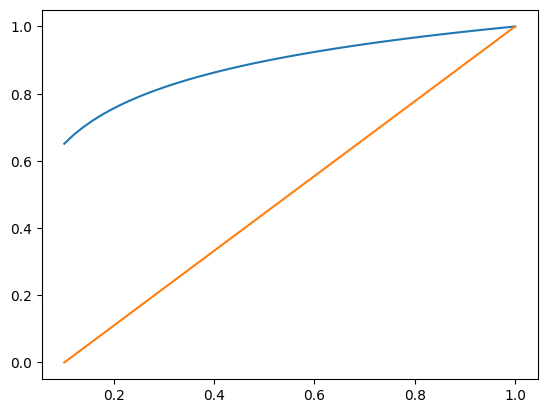

In [142]:
import numpy as np
from matplotlib import pyplot as plt

pressure_range = np.linspace(p0 / 1e5, 10) * 1e5
ex_T, ex_M = calc_physical_exergy(pressure_range, h_out, p0, T0, fluid)

ex_T_in, ex_M_in = calc_physical_exergy(p_in, h_in, p0, T0, fluid)

pressure_ratio = pressure_range / p_in
exergy_destruction_total = ex_in - (ex_M + ex_T)
exergy_destruction_ratio = exergy_destruction_total / ex_in
thermal_exergy_destrution_ratio = ex_T / ex_T_in
mechanical_exergy_destrution_ratio = ex_M / ex_M_in


exergy_destruction_total
exergy_destruction_ratio
plt.plot(pressure_ratio, thermal_exergy_destrution_ratio)
plt.plot(pressure_ratio, mechanical_exergy_destrution_ratio)

## Lessons Learned

- What did you learn?
- What should you be able to apply yourself?